# Classification Algorithms — Visual Demo Notebook

This notebook is designed as an **in-class demo** to build intuition for common classification algorithms:

- Logistic Regression  
- Naive Bayes (Gaussian + a tiny Bernoulli example)  
- k-Nearest Neighbors (kNN)  
- Support Vector Machines (SVM)  
- Decision Trees  
- Random Forests  

We focus on **2D datasets** so we can *see* the decision boundaries.  
All examples are self-contained (no external downloads).

> Tip for teaching: run top-to-bottom once, then jump between sections depending on time.


In [1]:
# --- Setup (run once) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_blobs, make_moons, make_classification

# Matplotlib: slightly larger default
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True

rng = np.random.default_rng(42)

def plot_points(ax, X, y, title=None):
    """Scatter plot for 2D points."""
    ax.scatter(X[:, 0], X[:, 1], c=y, s=35, edgecolor="k", alpha=0.85)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title:
        ax.set_title(title)

def plot_decision_boundary(ax, model, X, y, title=None, step=0.02, show_proba=False):
    """Decision boundary for a fitted binary classifier on 2D data."""
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]

    if show_proba and hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)[:, 1]
        Z = Z.reshape(xx.shape)
        cs = ax.contourf(xx, yy, Z, levels=30, alpha=0.75)
        plt.colorbar(cs, ax=ax, label="$P(y=1\mid x)$")
        ax.contour(xx, yy, Z, levels=[0.5], linewidths=2)
    else:
        Z = model.predict(grid).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.35)

    plot_points(ax, X, y, title=title)

def eval_binary(model, X_train, y_train, X_test, y_test, name):
    """Fit, predict and return metrics."""
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return {"model": name, "accuracy": acc, "f1": f1, "pred": pred}

print("Ready.")


Ready.


## 1) Toy datasets we can *see*

We'll use 3 datasets (all 2D, binary):

1. **Linearly separable**: a problem where a straight line works well.  
2. **Moons**: non-linear boundary needed.  
3. **Overlapping blobs**: probabilistic models (Naive Bayes) behave nicely here.

We'll keep the same train/test split per dataset to compare methods fairly.


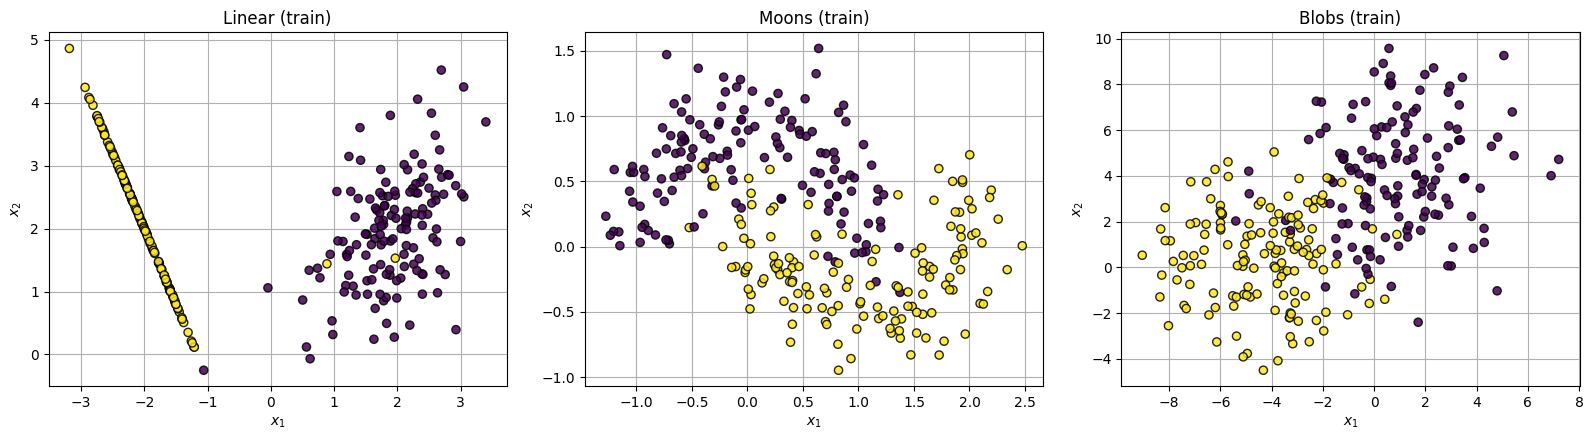

In [2]:
# --- Create datasets ---
# Dataset A: linearly separable
X_lin, y_lin = make_classification(
    n_samples=400, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=2.0, flip_y=0.03, random_state=1
)

# Dataset B: moons (non-linear)
X_moon, y_moon = make_moons(n_samples=400, noise=0.25, random_state=2)

# Dataset C: overlapping blobs (nice for GaussianNB intuition)
X_blob, y_blob = make_blobs(n_samples=400, centers=2, cluster_std=2.2, random_state=3)

def split(X, y, test_size=0.30, seed=0):
    return train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

splits = {
    "Linear": split(X_lin, y_lin, seed=10),
    "Moons":  split(X_moon, y_moon, seed=11),
    "Blobs":  split(X_blob, y_blob, seed=12),
}

# --- Visualize ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
for ax, (name, (Xtr, Xte, ytr, yte)) in zip(axes, splits.items()):
    plot_points(ax, Xtr, ytr, title=f"{name} (train)")
plt.tight_layout()
plt.show()


## 2) Logistic Regression

### Mental model
Logistic regression computes a **linear score** and maps it to a probability using the sigmoid:

$$
z = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

$$
P(y=1\mid x)=\sigma(z)=\frac{1}{1+e^{-z}}
$$

The decision boundary at threshold 0.5 is:

$$
\beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0
$$

### Why scaling?
For gradient-based training and regularization, scaling often makes optimization and the meaning of $C$ more stable.


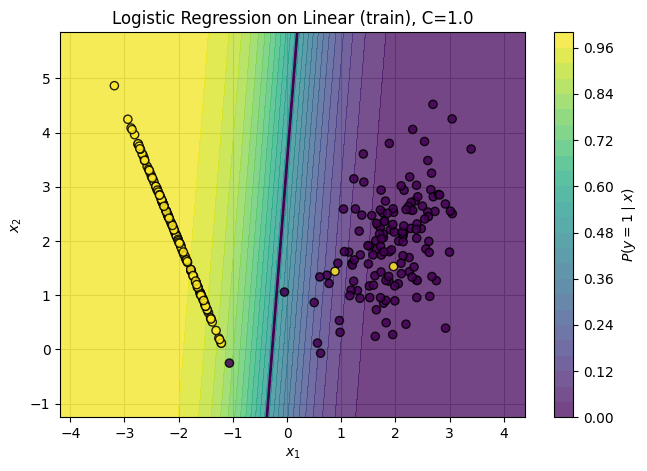

Test accuracy=0.983, F1=0.983


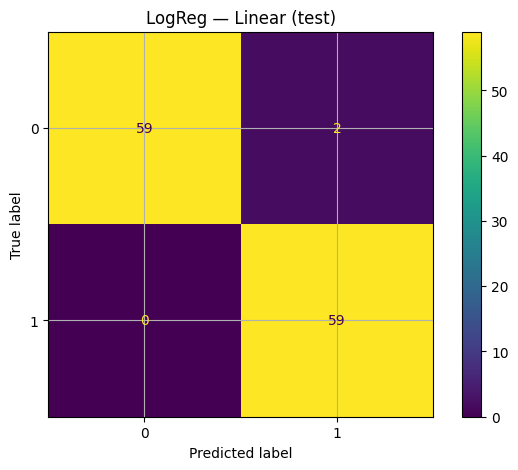

In [3]:
def demo_logreg(dataset_name, C=1.0):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=C, solver="lbfgs"))
    ])
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"Logistic Regression on {dataset_name} (train), C={C}",
                           show_proba=True)
    plt.show()

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"Test accuracy={acc:.3f}, F1={f1:.3f}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
    plt.title(f"LogReg — {dataset_name} (test)")
    plt.show()

demo_logreg("Linear", C=1.0)


### Regularization knob $C$

- **Small $C$** = stronger regularization → simpler boundary (higher bias)  
- **Large $C$** = weaker regularization → tries harder to fit training data (higher variance)

Let's visualize how the boundary changes.


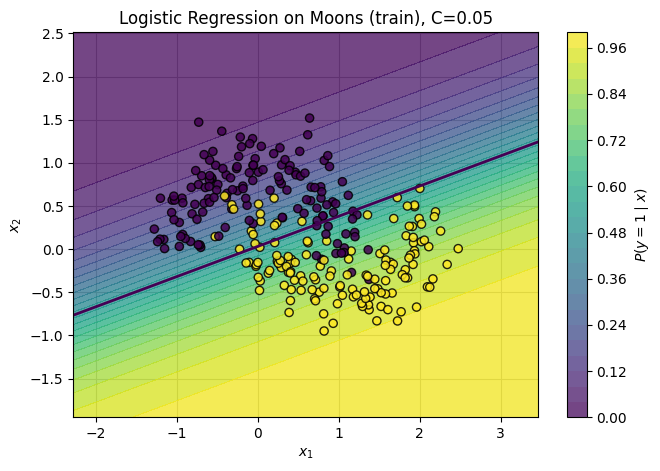

Test accuracy=0.850, F1=0.842


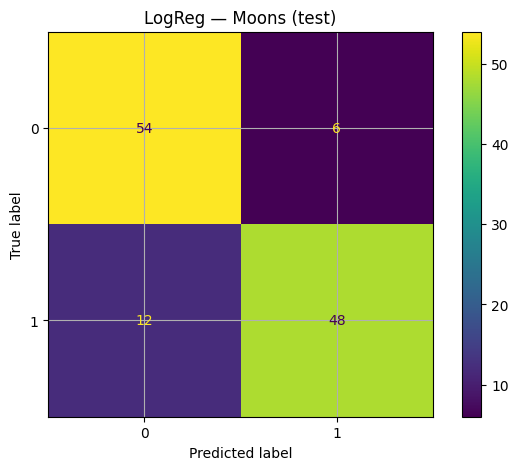

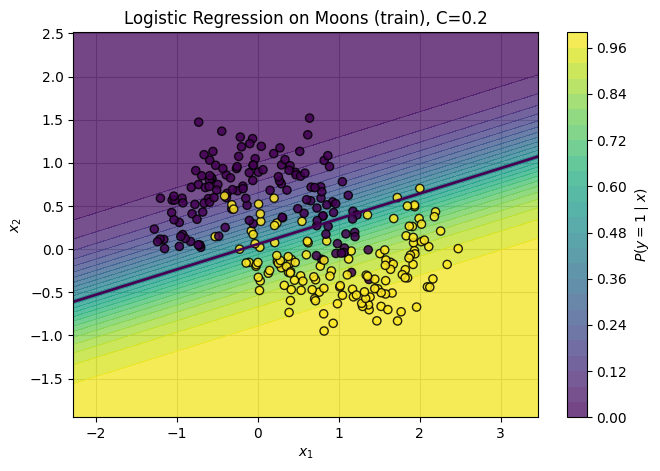

Test accuracy=0.833, F1=0.825


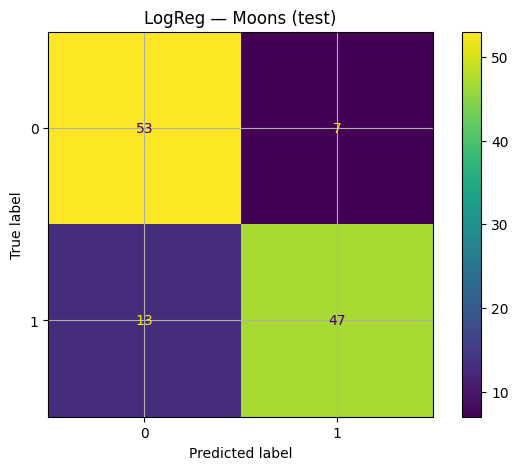

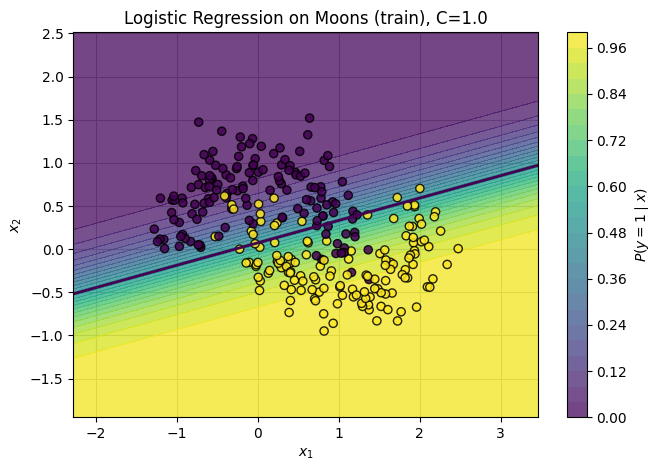

Test accuracy=0.842, F1=0.835


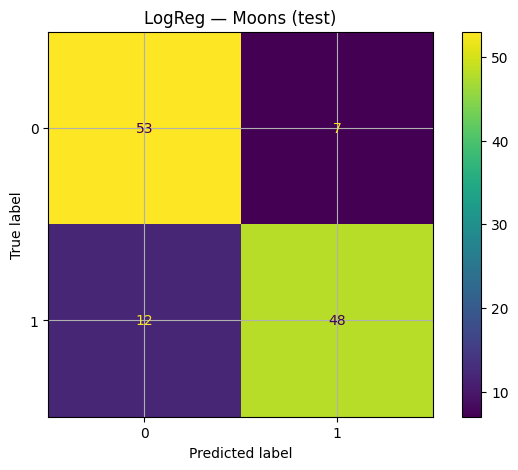

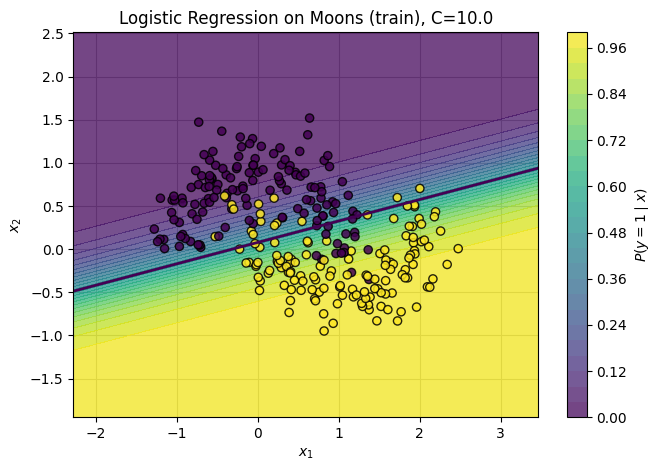

Test accuracy=0.842, F1=0.835


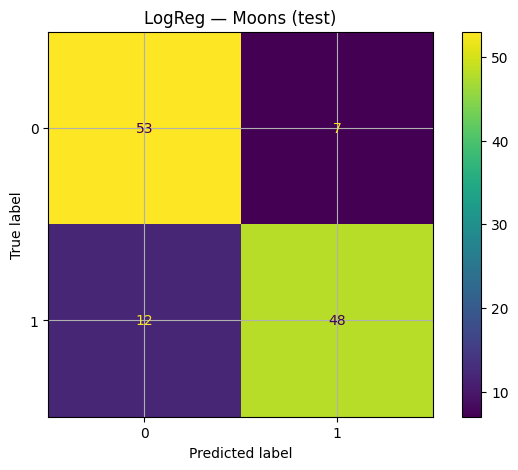

In [4]:
for C in [0.05, 0.2, 1.0, 10.0]:
    demo_logreg("Moons", C=C)


## 3) Naive Bayes

### Key assumption
Naive Bayes assumes **conditional independence** of features given the class:

$$
P(x_1, x_2, \dots, x_d \mid y) \approx \prod_{j=1}^d P(x_j \mid y)
$$

We'll demo **Gaussian Naive Bayes** (continuous features).  
It models each feature as a Gaussian within each class.

Intuition: it learns *class-wise bell curves*, then uses Bayes' rule to compute the posterior.


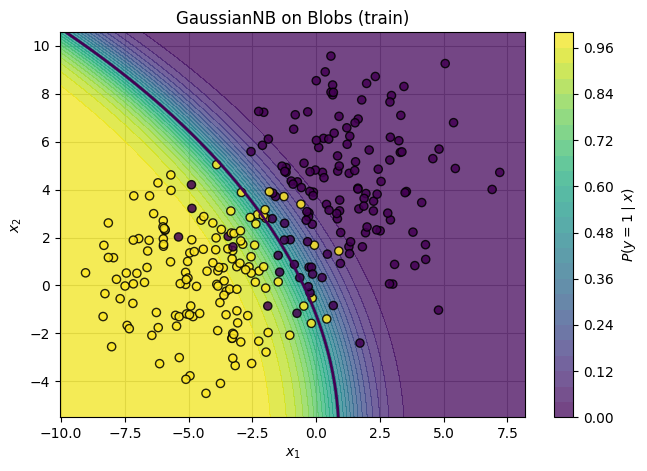

Test accuracy=0.933, F1=0.931


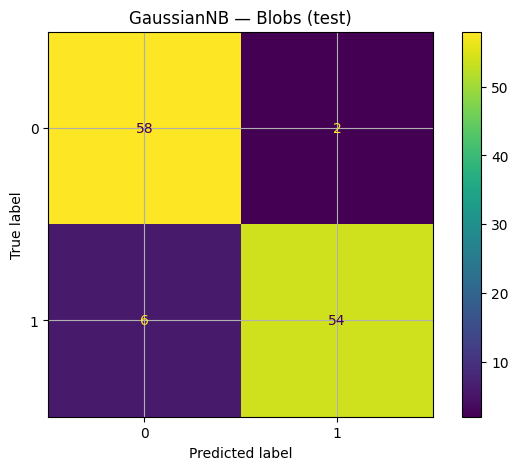

In [5]:
def demo_gaussian_nb(dataset_name):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = GaussianNB()
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"GaussianNB on {dataset_name} (train)",
                           show_proba=True)
    plt.show()

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"Test accuracy={acc:.3f}, F1={f1:.3f}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
    plt.title(f"GaussianNB — {dataset_name} (test)")
    plt.show()

demo_gaussian_nb("Blobs")


### Mini example: Bernoulli Naive Bayes (binary features)

A classic toy problem: spam detection with binary features like "contains the word *discount*".

We'll compute the result in two ways:
1) Using `BernoulliNB`  
2) Manually via simple counting + Bayes rule (to show what's inside the black box)


In [6]:
# Tiny dataset (from the lecture/assignment style)
df = pd.DataFrame({
    "D": [1,0,1,0,1,1,0,0,1,1],  # discount
    "U": [1,0,0,1,0,1,1,1,1,0],  # urgent
    "F": [0,1,1,0,0,0,1,0,1,1],  # free
    "spam": [1,0,1,0,0,1,1,1,1,0]
})
X = df[["D","U","F"]].values
y = df["spam"].values

x_new = np.array([[1,0,0]])  # D=1, U=0, F=0

bnb = BernoulliNB(alpha=1.0)  # Laplace smoothing
bnb.fit(X, y)

proba = bnb.predict_proba(x_new)[0]
print("BernoulliNB posteriors:")
print(f" P(spam=0|x)={proba[0]:.3f}")
print(f" P(spam=1|x)={proba[1]:.3f}")
print("Prediction:", int(bnb.predict(x_new)[0]))

# --- Manual (with Laplace smoothing) ---
alpha = 1.0
classes = [0, 1]
N = len(df)

priors = {}
cond = {c: {} for c in classes}

for c in classes:
    dfc = df[df["spam"] == c]
    priors[c] = len(dfc) / N
    for col in ["D","U","F"]:
        # Bernoulli: P(feature=1 | class)
        p1 = (dfc[col].sum() + alpha) / (len(dfc) + 2*alpha)
        cond[c][col] = p1

def bernoulli_likelihood(x, c):
    # x is 0/1 vector
    p = 1.0
    for val, col in zip(x, ["D","U","F"]):
        p1 = cond[c][col]
        p *= (p1 if val == 1 else (1 - p1))
    return p

unnorm = {c: bernoulli_likelihood(x_new[0], c) * priors[c] for c in classes}
Z = sum(unnorm.values())
post = {c: unnorm[c]/Z for c in classes}

print("\nManual calculation (same idea as the model):")
print("Priors:", priors)
print("P(feature=1|class):", cond)
print("Posterior:", post)


BernoulliNB posteriors:
 P(spam=0|x)=0.587
 P(spam=1|x)=0.413
Prediction: 0

Manual calculation (same idea as the model):
Priors: {0: 0.4, 1: 0.6}
P(feature=1|class): {0: {'D': 0.5, 'U': 0.3333333333333333, 'F': 0.5}, 1: {'D': 0.625, 'U': 0.75, 'F': 0.5}}
Posterior: {0: 0.5871559633027523, 1: 0.4128440366972477}


## 4) k-Nearest Neighbors (kNN)

kNN is **instance-based**:
- "Training" is basically storing the dataset.
- Prediction: compute distances to all points, take the majority vote among the *k* closest.

### Hyperparameter $k$
- **Small $k$** → jagged boundary (high variance, sensitive to noise/outliers)  
- **Large $k$** → smoother boundary (high bias)


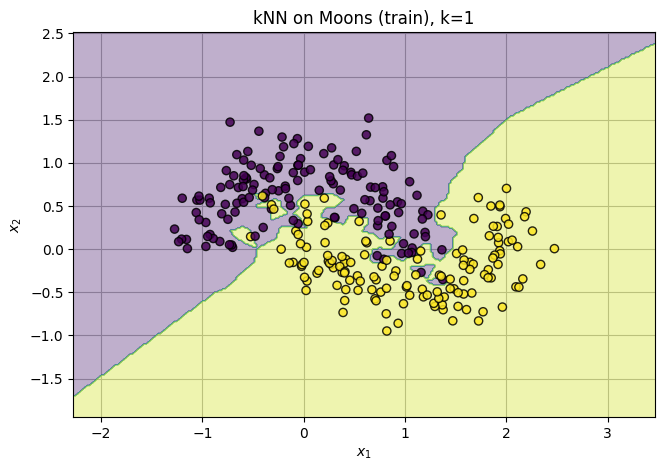

Test accuracy=0.925, F1=0.927


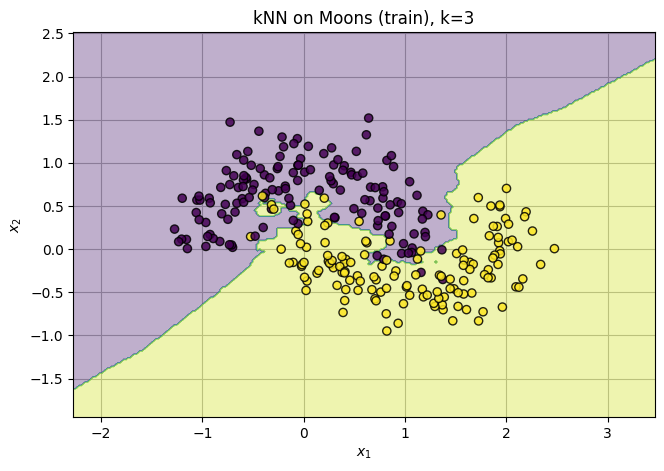

Test accuracy=0.933, F1=0.933


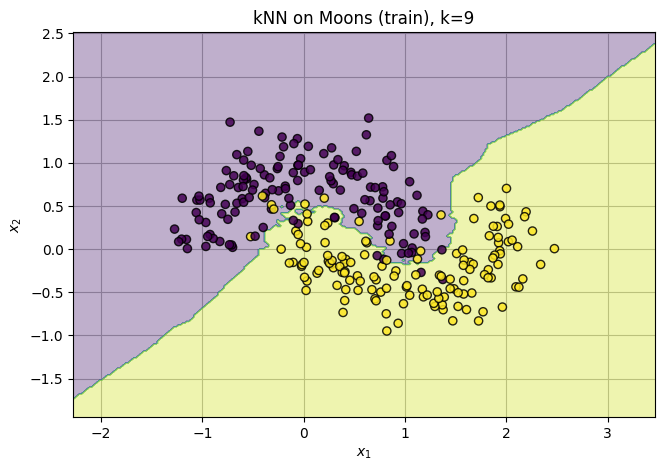

Test accuracy=0.933, F1=0.932


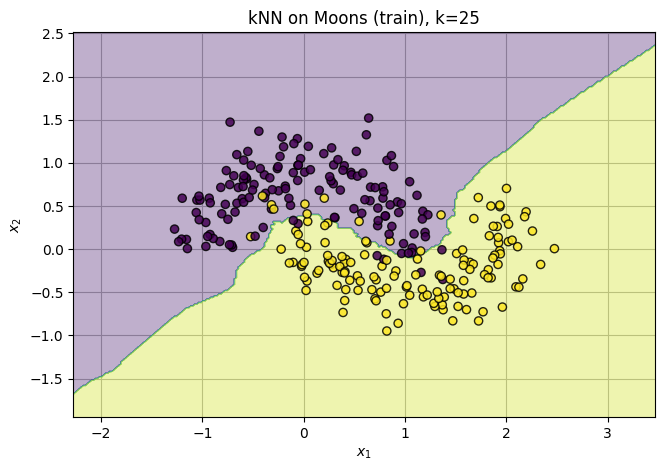

Test accuracy=0.925, F1=0.924


In [7]:
def demo_knn(dataset_name, k):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"kNN on {dataset_name} (train), k={k}")
    plt.show()

    pred = model.predict(X_test)
    print(f"Test accuracy={accuracy_score(y_test, pred):.3f}, F1={f1_score(y_test, pred):.3f}")

for k in [1, 3, 9, 25]:
    demo_knn("Moons", k=k)


## 5) Support Vector Machines (SVM)

### Linear SVM: maximum-margin separator
For linearly separable data, SVM selects the separating hyperplane with the **largest margin**.

### Soft margin and parameter $C$
- **Low $C$**: tolerate more violations → wider margin, simpler boundary  
- **High $C$**: penalize mistakes strongly → narrower margin, more complex boundary

We'll show:
1) Linear SVM with *support vectors* highlighted  
2) RBF-kernel SVM for non-linear separation (moons)


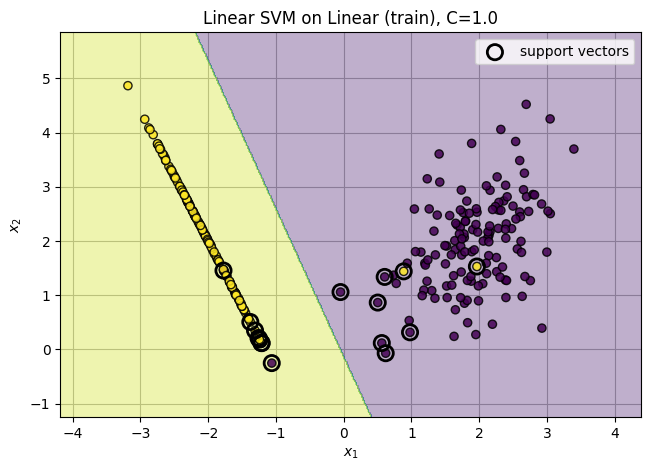

Test accuracy=0.983, F1=0.983


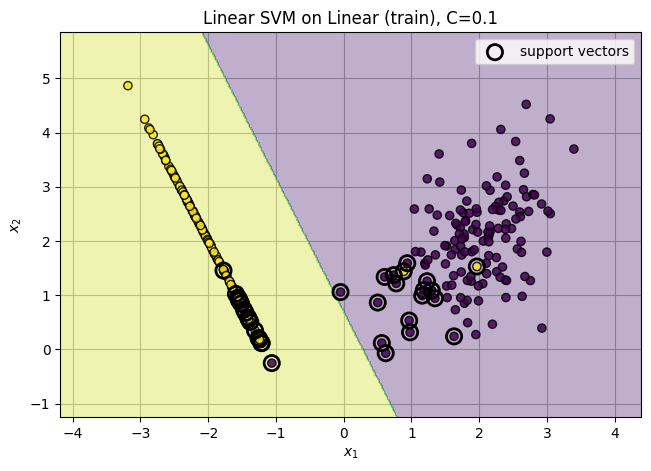

Test accuracy=0.983, F1=0.983


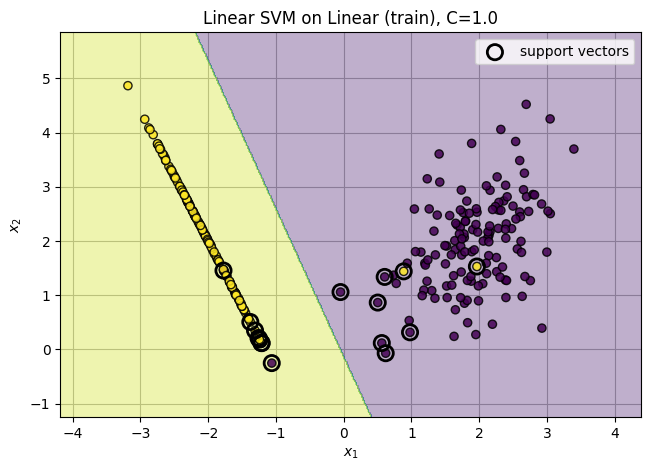

Test accuracy=0.983, F1=0.983


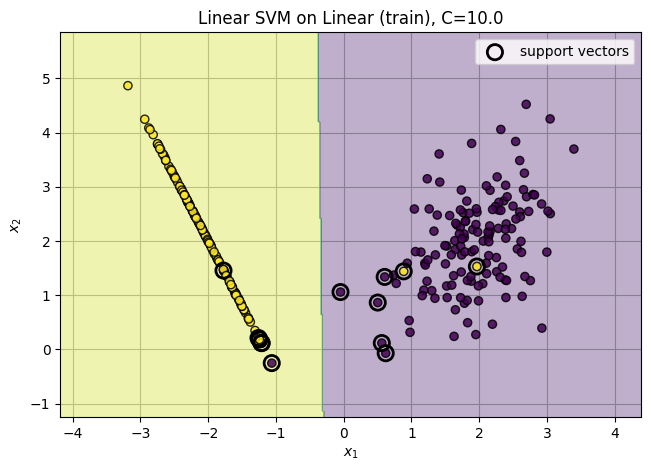

Test accuracy=0.983, F1=0.983


In [8]:
def demo_linear_svm(dataset_name, C=1.0):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="linear", C=C, probability=True))
    ])
    model.fit(X_train, y_train)

    # Plot boundary
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"Linear SVM on {dataset_name} (train), C={C}",
                           show_proba=False)

    # Highlight support vectors (need access to underlying SVC after scaling)
    svc = model.named_steps["clf"]
    scaler = model.named_steps["scaler"]
    Xs = scaler.transform(X_train)
    sv = scaler.inverse_transform(svc.support_vectors_)
    ax.scatter(sv[:, 0], sv[:, 1], s=120, facecolors="none", edgecolors="k", linewidths=2, label="support vectors")
    ax.legend()
    plt.show()

    pred = model.predict(X_test)
    print(f"Test accuracy={accuracy_score(y_test, pred):.3f}, F1={f1_score(y_test, pred):.3f}")

demo_linear_svm("Linear", C=1.0)

for C in [0.1, 1.0, 10.0]:
    demo_linear_svm("Linear", C=C)


## RBF Kernel SVM — Non-Linear Decision Boundaries

So far, the linear SVM searched for a separating **hyperplane**:

$$
w^T x + b = 0
$$

But what if the data is *not linearly separable* (e.g., the Moons dataset)?

Instead of explicitly transforming the features into a higher-dimensional space, SVM uses the **kernel trick**.

---

### The Kernel Trick

A kernel function computes similarity between two samples:

$$
K(x, x') = \phi(x)^T \phi(x')
$$

without explicitly computing the transformation $\phi(x)$.

For the **Radial Basis Function (RBF) kernel**, the similarity is:

$$
K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right)
$$

This means:

- Points that are **close together** → similarity ≈ 1  
- Points that are **far apart** → similarity ≈ 0  

Each training point effectively creates a smooth “bump” in feature space.

---

### Intuition

You can think of RBF SVM as:

- Placing a Gaussian-shaped influence around each support vector  
- Combining these influences linearly  
- Producing highly flexible, curved decision boundaries  

The model remains a **maximum-margin classifier**, but in an implicitly higher-dimensional space.

---

### Hyperparameters

#### $C$ — Regularization strength
- Small $C$ → wider margin, more tolerance for misclassification (higher bias)
- Large $C$ → narrower margin, tries harder to classify all training points correctly (higher variance)

#### $\gamma$ — Kernel width
Controls how local each support vector's influence is.

- Small $\gamma$ → wide Gaussians → smoother boundary (higher bias)
- Large $\gamma$ → narrow Gaussians → very flexible boundary (higher variance, risk of overfitting)

---

### Why Scaling Matters

Because the kernel depends on squared Euclidean distance:

$$
\|x - x'\|^2
$$

feature scaling is critical. Otherwise, features with larger numeric range dominate the similarity measure.

---

Now we visualize how the RBF SVM behaves on a non-linear dataset.


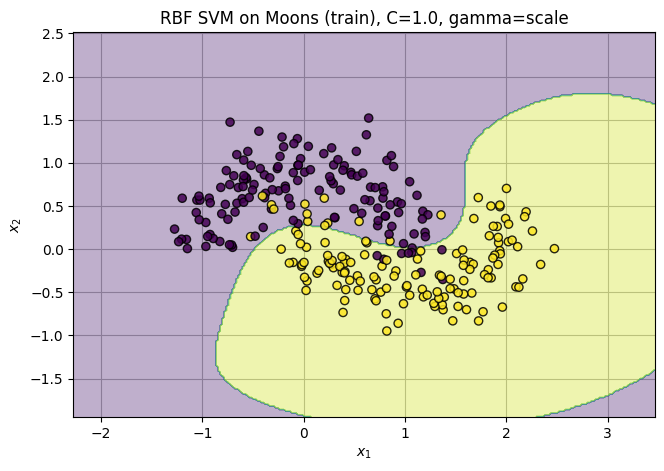

Test accuracy=0.900, F1=0.900


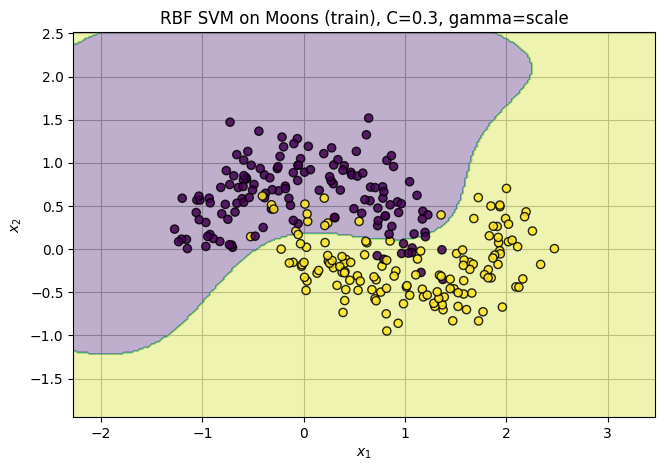

Test accuracy=0.875, F1=0.872


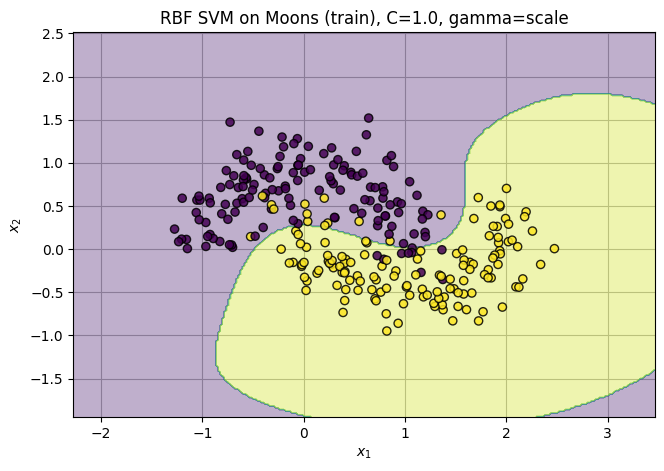

Test accuracy=0.900, F1=0.900


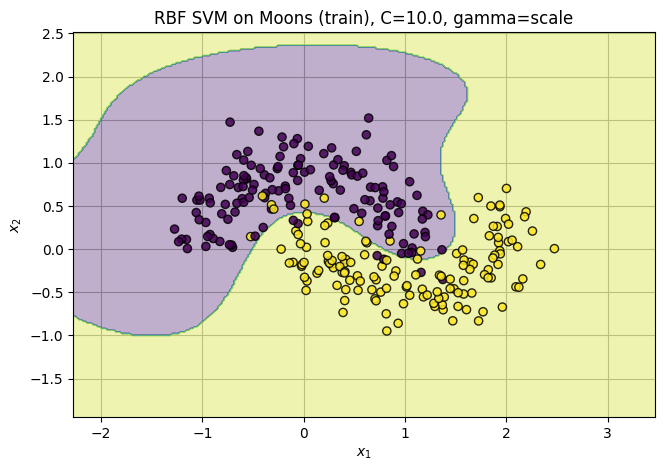

Test accuracy=0.933, F1=0.933


In [9]:
def demo_rbf_svm(dataset_name, C=1.0, gamma="scale"):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=C, gamma=gamma, probability=True))
    ])
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"RBF SVM on {dataset_name} (train), C={C}, gamma={gamma}",
                           show_proba=False)
    plt.show()

    pred = model.predict(X_test)
    print(f"Test accuracy={accuracy_score(y_test, pred):.3f}, F1={f1_score(y_test, pred):.3f}")

demo_rbf_svm("Moons", C=1.0, gamma="scale")
for C in [0.3, 1.0, 10.0]:
    demo_rbf_svm("Moons", C=C, gamma="scale")


## 6) Decision Trees

### Intuition
A decision tree performs **recursive binary splitting**:
- Each split asks a yes/no question like *$x_1 < t$?*
- Splits are **axis-aligned** → boundaries look like rectangles/stairs

### Main knobs (regularization)
- `max_depth`  
- `min_samples_leaf`  

These control overfitting (variance).


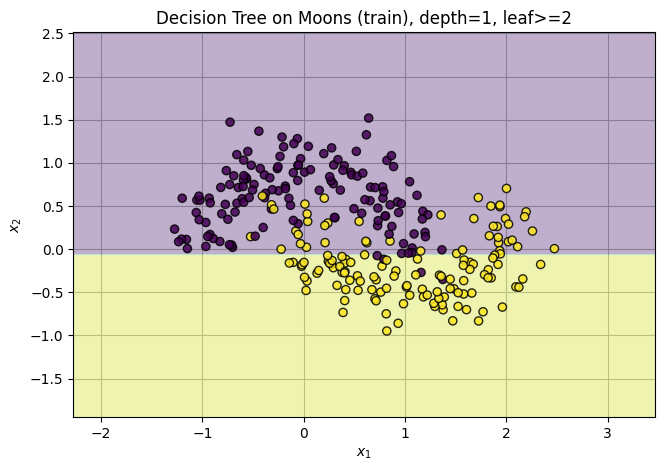

Test accuracy=0.750, F1=0.706


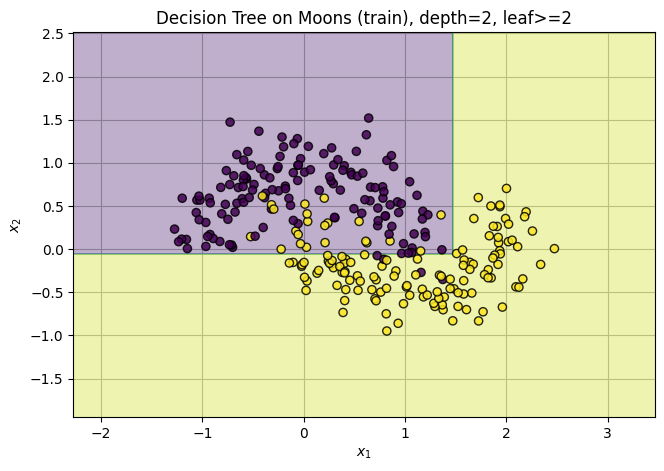

Test accuracy=0.833, F1=0.821


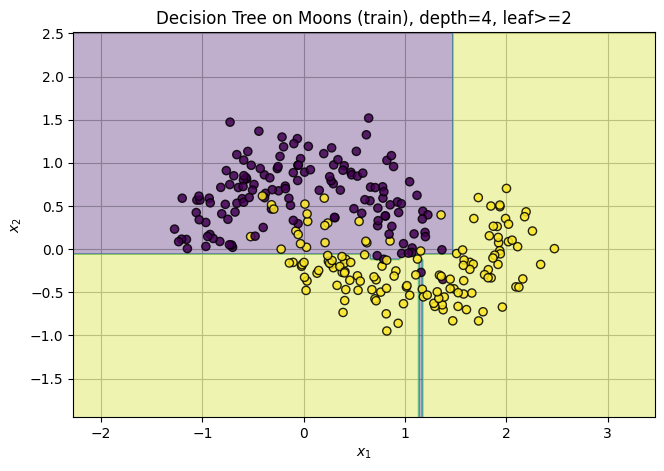

Test accuracy=0.825, F1=0.807


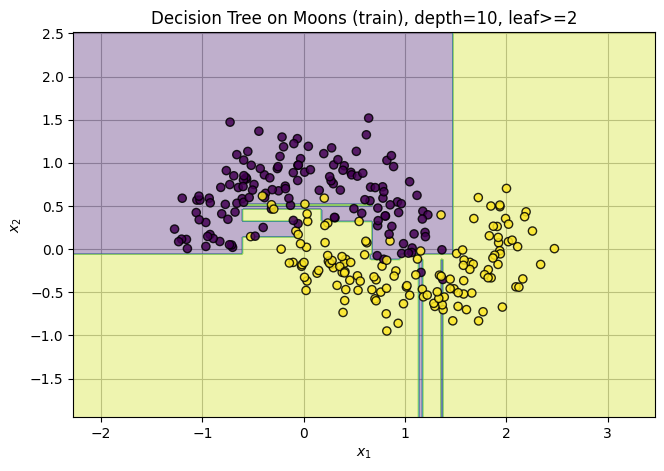

Test accuracy=0.875, F1=0.880


In [10]:
def demo_tree_boundary(dataset_name, max_depth=None, min_samples_leaf=1):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, model, X_train, y_train,
                           title=f"Decision Tree on {dataset_name} (train), depth={max_depth}, leaf>={min_samples_leaf}")
    plt.show()

    pred = model.predict(X_test)
    print(f"Test accuracy={accuracy_score(y_test, pred):.3f}, F1={f1_score(y_test, pred):.3f}")

for depth in [1, 2, 4, 10]:
    demo_tree_boundary("Moons", max_depth=depth, min_samples_leaf=2)


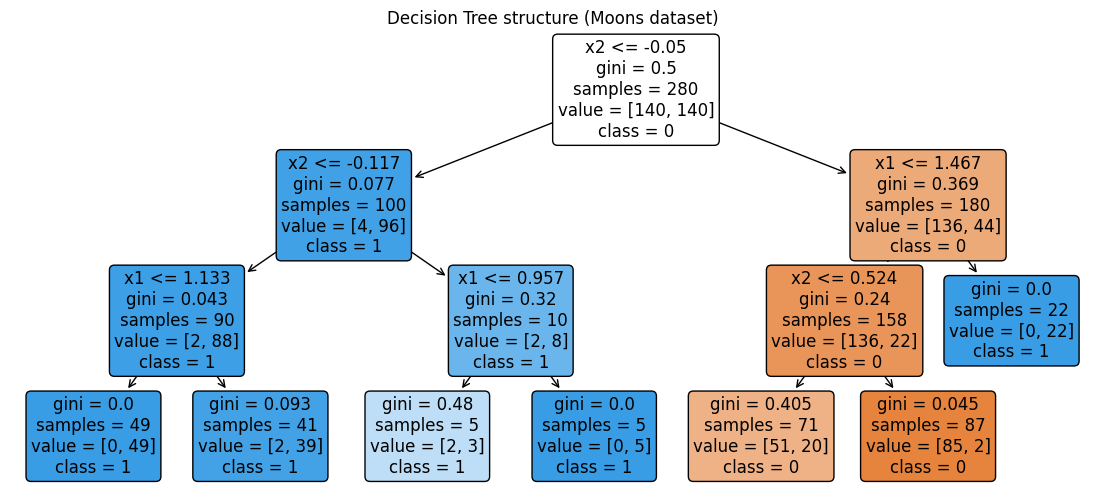

In [11]:
# Plot the actual tree (small depth so it's readable)
X_train, X_test, y_train, y_test = splits["Moons"]
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=0)
dt.fit(X_train, y_train)

plt.figure(figsize=(14, 6))
plot_tree(dt, filled=True, feature_names=["x1", "x2"], class_names=["0", "1"], rounded=True)
plt.title("Decision Tree structure (Moons dataset)")
plt.show()


## 7) Random Forest

A Random Forest is an **ensemble of trees**:
- Each tree is trained on a **bootstrap sample** of the data (bagging).
- At each split, a tree considers a **random subset of features** (feature bagging).

Effect:
- Individual trees have **high variance**
- Averaging/voting over many trees reduces variance → smoother, more robust decision boundary


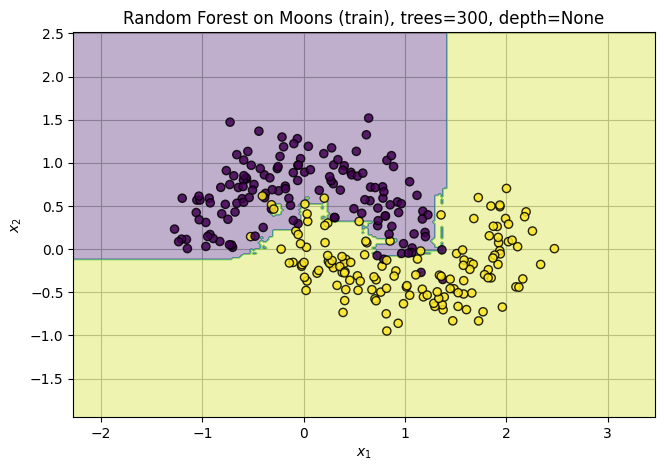

Test accuracy=0.942, F1=0.943


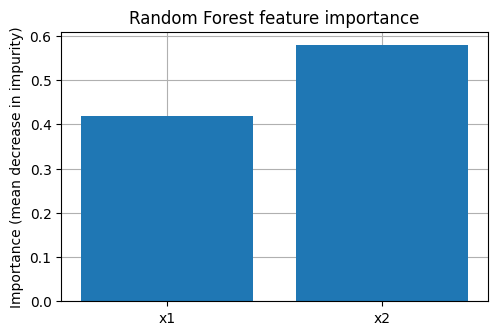

In [12]:
def demo_rf(dataset_name, n_estimators=200, max_depth=None):
    X_train, X_test, y_train, y_test = splits[dataset_name]
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0
    )
    rf.fit(X_train, y_train)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.0))
    plot_decision_boundary(ax, rf, X_train, y_train,
                           title=f"Random Forest on {dataset_name} (train), trees={n_estimators}, depth={max_depth}")
    plt.show()

    pred = rf.predict(X_test)
    print(f"Test accuracy={accuracy_score(y_test, pred):.3f}, F1={f1_score(y_test, pred):.3f}")

    # Feature importance (only 2 features here, but still instructive)
    imp = rf.feature_importances_
    plt.figure(figsize=(5.5, 3.5))
    plt.bar(["x1", "x2"], imp)
    plt.ylabel("Importance (mean decrease in impurity)")
    plt.title("Random Forest feature importance")
    plt.grid(True, axis="y")
    plt.show()

demo_rf("Moons", n_estimators=300, max_depth=None)


## 8) Side-by-side comparison on one dataset

We'll compare **all models** on the *same* train/test split for the Moons dataset:

- Logistic Regression (scaled)
- GaussianNB
- kNN (k=9, scaled)
- SVM (RBF kernel, scaled)
- Decision Tree
- Random Forest

We summarize Accuracy and F1, and also show confusion matrices.


,Model,Accuracy,F1
5,RandomForest (300 trees),0.941667,0.943089
2,kNN (k=9),0.933333,0.932203
3,SVM (RBF),0.900000,0.900000
1,GaussianNB,0.850000,0.842105
0,LogisticRegression,0.841667,0.834783
4,DecisionTree (depth=4),0.833333,0.821429


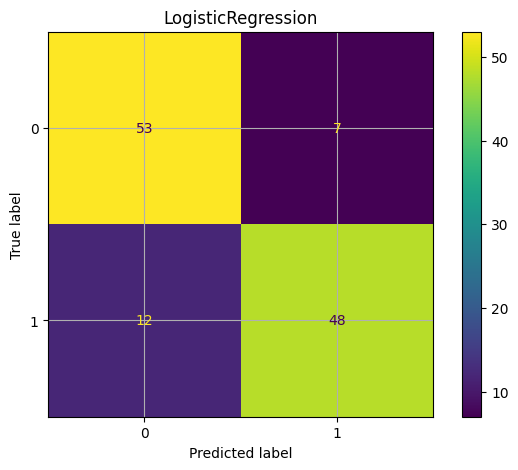

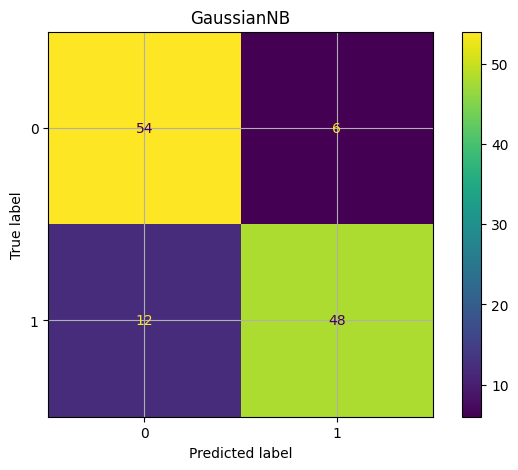

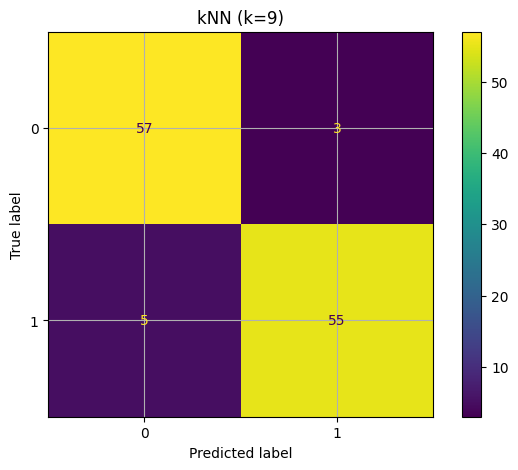

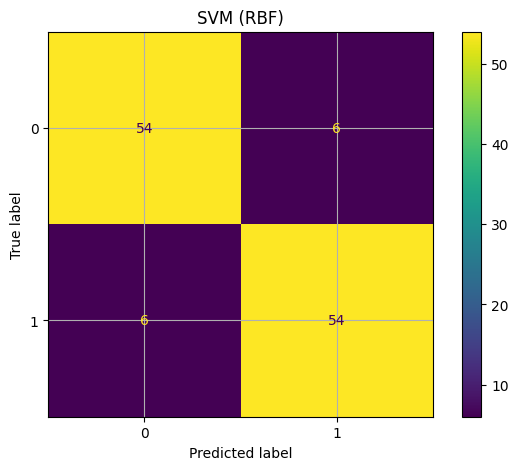

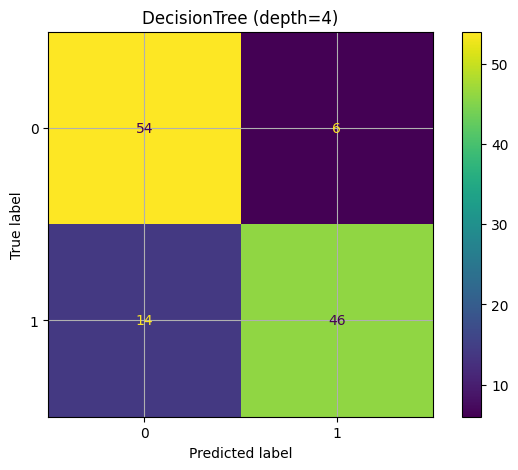

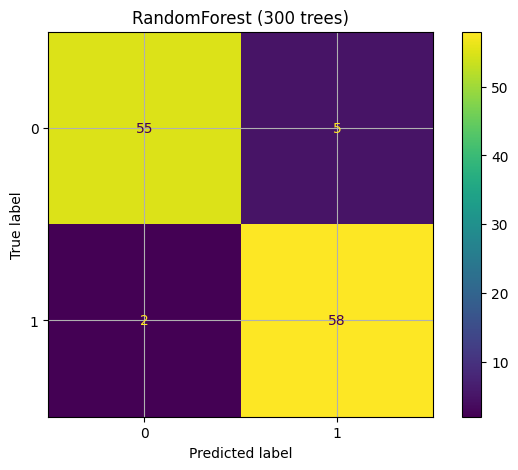

In [13]:
X_train, X_test, y_train, y_test = splits["Moons"]

models = [
    (Pipeline([("scaler", StandardScaler()),
               ("clf", LogisticRegression(C=1.0))]), "LogisticRegression"),
    (GaussianNB(), "GaussianNB"),
    (Pipeline([("scaler", StandardScaler()),
               ("clf", KNeighborsClassifier(n_neighbors=9))]), "kNN (k=9)"),
    (Pipeline([("scaler", StandardScaler()),
               ("clf", SVC(kernel='rbf', C=1.0, gamma='scale'))]), "SVM (RBF)"),
    (DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0), "DecisionTree (depth=4)"),
    (RandomForestClassifier(n_estimators=300, random_state=0), "RandomForest (300 trees)"),
]

rows = []
preds = {}

for m, name in models:
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    preds[name] = pred
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    })

df_scores = pd.DataFrame(rows).sort_values(["F1", "Accuracy"], ascending=False)
display(df_scores)

# Confusion matrices
for name, pred in preds.items():
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
    plt.title(name)
    plt.show()


## 9) What to emphasize verbally (teaching notes)

- **Logistic Regression**: linear separator + probability; regularization is a *simplicity knob*.
- **Naive Bayes**: *generative story* (model class distributions); independence assumption → fast & surprisingly good in some domains.
- **kNN**: "lazy learner"; boundary complexity controlled by $k$; prediction is expensive for large $N$.
- **SVM**: margin intuition; $C$ balances margin vs errors; kernels enable non-linear boundaries.
- **Decision Trees**: interpretable rules, but unstable/high-variance; axis-aligned splits.
- **Random Forest**: reduces tree variance via bagging + feature randomness; robust default classifier.

If you want, I can also add a **short 'engineering dataset' section** (e.g., Banknote authentication) so the demo transitions from toy 2D plots to a realistic tabular dataset.
